In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [2]:
df = pd.read_csv('dataframe_train.csv')

In [3]:
# Basic visual setting
pd.set_option('display.max_columns',df.shape[1])
pd.set_option('display.float_format', '{:,.6f}'.format)

In [4]:
# Know the dataset
df.head()
df.tail()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509604 entries, 0 to 509603
Data columns (total 25 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   courier_id              509604 non-null  int64  
 1   wave_index              509604 non-null  int64  
 2   tracking_id             509604 non-null  float64
 3   courier_wave_start_lng  509604 non-null  float64
 4   courier_wave_start_lat  509604 non-null  float64
 5   action_type             509604 non-null  object 
 6   date                    509604 non-null  int64  
 7   group                   509604 non-null  float64
 8   level                   509604 non-null  int64  
 9   speed                   509604 non-null  float64
 10  max_load                509604 non-null  int64  
 11  weather_grade           509604 non-null  object 
 12  aoi_id                  509604 non-null  object 
 13  shop_id                 509604 non-null  object 
 14  id                  

In [5]:
# For object data type, print the feature details
for col in df.select_dtypes(include = 'object').columns:
    print(col, ':', df[col].unique(), ',', 'Numbers:',df[col].nunique(),'\n')

action_type : ['PICKUP' 'DELIVERY'] , Numbers: 2 

weather_grade : ['Normal Weather' 'Very Bad Weather' 'Bad Weather' 'Slightly Bad Weather'] , Numbers: 4 

aoi_id : ['81141ae62972bc11642cde98fd667df0' 'b71df7214347524a0f5f0c79dfdf2f4e'
 '753c1911e8a294c5db901f8555faff0c' ... '92a1a014e071c0488aea06740ad36b7a'
 '8df4ba59835581008f1b872abe13660c' 'b0f93a266abc6dcdc682659ff58e9994'] , Numbers: 34912 

shop_id : ['944b7864d46e8a1aece1319212c9ae88' '88ac051764fe348382e6529948de8015'
 '92ec52685bd511da262ee6f7a0adaa87' ... '5527fde6b61dad5536dd881cec202704'
 '7bedf053333c3010aab730ab194efd59' '4c16b68804c28b21b8d933cbca64a0eb'] , Numbers: 11193 

source_type : ['ASSIGN' 'PICKUP' 'DELIVERY'] , Numbers: 3 



In [6]:
# print the column names
df.columns

Index(['courier_id', 'wave_index', 'tracking_id', 'courier_wave_start_lng',
       'courier_wave_start_lat', 'action_type', 'date', 'group', 'level',
       'speed', 'max_load', 'weather_grade', 'aoi_id', 'shop_id', 'id',
       'source_type', 'source_tracking_id', 'source_lng', 'source_lat',
       'target_lng', 'target_lat', 'grid_distance', 'expected_use_time',
       'urgency', 'hour'],
      dtype='object')

# Feature Selection

In [7]:
# drop variables that are irrelavant to predict the target
df.drop(['wave_index', 'courier_id', 'tracking_id', 'date', 'group', 'action_type',
         'aoi_id', 'shop_id', 'source_tracking_id', 'id'],axis = 1, inplace = True)


# Encode weather condition into ordinal number, source type into dummy variables
df['weather_grade'].replace({'Very Bad Weather':1, 'Bad Weather':2,
                             'Slightly Bad Weather':3, 'Normal Weather':4}, inplace = True)
df = pd.get_dummies(data = df, columns = ['source_type'], drop_first = True)
# df = pd.get_dummies(data = df, columns = ['action_type'])
# df.drop(['action_type_PICKUP'], axis = 1, inplace = True)

In [8]:
df.head()

,courier_wave_start_lng,courier_wave_start_lat,level,speed,max_load,weather_grade,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour,source_type_DELIVERY,source_type_PICKUP
0,121.630997,39.142343,3,4.751832,11,4,121.630997,39.142343,121.632547,39.141946,377.000000,804,1246,11,0,0
1,121.630997,39.142343,3,4.751832,11,4,121.632547,39.141946,121.626144,39.140281,780.000000,298,1246,11,0,1
2,121.630997,39.142343,3,4.751832,11,4,121.626144,39.140281,121.631219,39.141811,550.000000,545,2462,11,1,0
3,121.630997,39.142343,3,4.751832,11,4,121.631219,39.141811,121.632084,39.146201,707.000000,341,1205,11,0,1
4,121.630997,39.142343,3,4.751832,11,4,121.632084,39.146201,121.631574,39.142231,770.000000,166,1882,11,1,0


In [9]:
df.describe()

,courier_wave_start_lng,courier_wave_start_lat,level,speed,max_load,weather_grade,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour,source_type_DELIVERY,source_type_PICKUP
count,"509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000"
mean,121.534935,39.179724,2.607338,5.348056,8.980295,3.497473,121.534923,39.179897,121.534882,39.179971,"1,078.274900",441.655107,"1,572.033695",14.482592,0.350729,0.500000
std,0.151081,0.114737,0.698855,0.626070,2.028490,1.013696,0.150718,0.113594,0.150752,0.113615,"1,124.569317",405.080785,"4,344.556228",3.310272,0.477199,0.500000
min,119.876654,36.064995,0.000000,3.008735,1.000000,1.000000,119.876654,36.064995,121.059274,38.826421,0.000000,1.000000,"-340,771.000000",6.000000,0.000000,0.000000
25%,121.444628,39.116955,2.000000,4.868302,8.000000,4.000000,121.444174,39.117340,121.444254,39.117201,330.000000,189.000000,859.000000,12.000000,0.000000,0.000000
50%,121.523819,39.162378,3.000000,5.458097,9.000000,4.000000,121.523930,39.161311,121.523587,39.161241,869.000000,354.000000,"1,752.000000",14.000000,0.000000,0.500000
75%,121.591983,39.218092,3.000000,5.779434,10.000000,4.000000,121.591344,39.218011,121.591347,39.218921,"1,572.000000",584.000000,"2,590.000000",17.000000,1.000000,1.000000
max,122.256382,39.705013,3.000000,6.943103,19.000000,4.000000,122.260124,39.705013,122.260124,39.695211,"429,173.000000","9,246.000000","11,345.000000",23.000000,1.000000,1.000000


In [10]:
import dataframe_image as dfi
dfi.export(obj = df.describe(), filename = 'des_reg.jpg', fontsize = 14, max_rows = None, max_cols=None)

objc[38943]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb50fb0ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x111910850). One of the two will be used. Which one is undefined.
56708 bytes written to file /var/folders/m0/xn5d3l091k97mhhzk0mjcwl40000gn/T/tmpqbwd1jyl/temp.png
objc[38967]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb50fb0ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x10e68d850). One of the two will be used. Which one is undefined.
56708 bytes written to file /var/folders/m0/xn5d3l091k97mhhzk0mjcwl40000gn/T/tmpha

56708 bytes written to file /var/folders/m0/xn5d3l091k97mhhzk0mjcwl40000gn/T/tmpurcj6wxc/temp.png
objc[39152]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb50fb0ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x10e601850). One of the two will be used. Which one is undefined.
56708 bytes written to file /var/folders/m0/xn5d3l091k97mhhzk0mjcwl40000gn/T/tmpqyhwo2vs/temp.png
objc[39163]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb50fb0ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x111c98850). One of the two will be used. Which on

objc[39338]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb50fb0ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x1120f0850). One of the two will be used. Which one is undefined.
56708 bytes written to file /var/folders/m0/xn5d3l091k97mhhzk0mjcwl40000gn/T/tmpqt7x149z/temp.png
objc[39349]: Class WebSwapCGLLayer is implemented in both /System/Library/Frameworks/WebKit.framework/Versions/A/Frameworks/WebCore.framework/Versions/A/Frameworks/libANGLE-shared.dylib (0x7ffb50fb0ec8) and /Applications/Google Chrome.app/Contents/Frameworks/Google Chrome Framework.framework/Versions/111.0.5563.64/Libraries/libGLESv2.dylib (0x110520850). One of the two will be used. Which one is undefined.
56708 bytes written to file /var/folders/m0/xn5d3l091k97mhhzk0mjcwl40000gn/T/tmpti

FileNotFoundError: [Errno 2] No such file or directory: '/var/folders/m0/xn5d3l091k97mhhzk0mjcwl40000gn/T/tmpso6mn2iw/temp.png'

# Process unreasonable values and outliers

In [11]:
df['urgency'] = abs(df['urgency'])
temp1 = df.copy()

temp1.describe()

,courier_wave_start_lng,courier_wave_start_lat,level,speed,max_load,weather_grade,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour,source_type_DELIVERY,source_type_PICKUP
count,"509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000","509,604.000000"
mean,121.534935,39.179724,2.607338,5.348056,8.980295,3.497473,121.534923,39.179897,121.534882,39.179971,"1,078.274900",441.655107,"2,292.373374",14.482592,0.350729,0.500000
std,0.151081,0.114737,0.698855,0.626070,2.028490,1.013696,0.150718,0.113594,0.150752,0.113615,"1,124.569317",405.080785,"4,011.418404",3.310272,0.477199,0.500000
min,119.876654,36.064995,0.000000,3.008735,1.000000,1.000000,119.876654,36.064995,121.059274,38.826421,0.000000,1.000000,0.000000,6.000000,0.000000,0.000000
25%,121.444628,39.116955,2.000000,4.868302,8.000000,4.000000,121.444174,39.117340,121.444254,39.117201,330.000000,189.000000,877.000000,12.000000,0.000000,0.000000
50%,121.523819,39.162378,3.000000,5.458097,9.000000,4.000000,121.523930,39.161311,121.523587,39.161241,869.000000,354.000000,"1,784.000000",14.000000,0.000000,0.500000
75%,121.591983,39.218092,3.000000,5.779434,10.000000,4.000000,121.591344,39.218011,121.591347,39.218921,"1,572.000000",584.000000,"2,641.000000",17.000000,1.000000,1.000000
max,122.256382,39.705013,3.000000,6.943103,19.000000,4.000000,122.260124,39.705013,122.260124,39.695211,"429,173.000000","9,246.000000","340,771.000000",23.000000,1.000000,1.000000


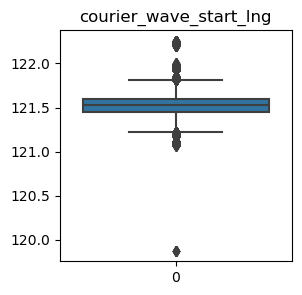

<Figure size 640x480 with 0 Axes>

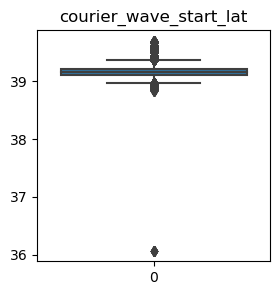

<Figure size 640x480 with 0 Axes>

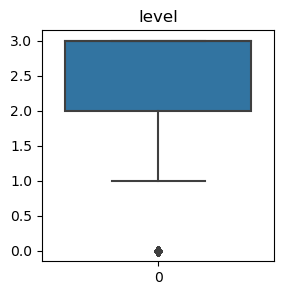

<Figure size 640x480 with 0 Axes>

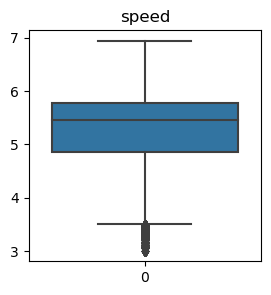

<Figure size 640x480 with 0 Axes>

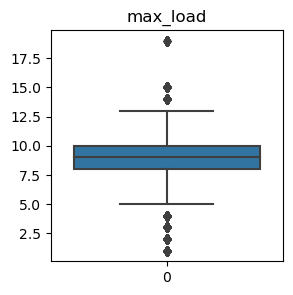

<Figure size 640x480 with 0 Axes>

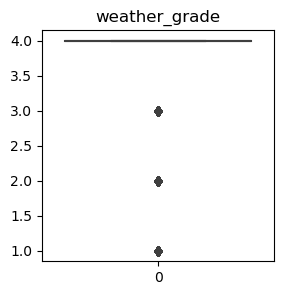

<Figure size 640x480 with 0 Axes>

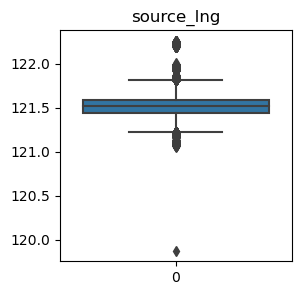

<Figure size 640x480 with 0 Axes>

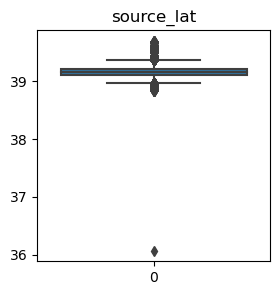

<Figure size 640x480 with 0 Axes>

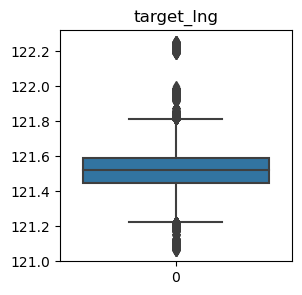

<Figure size 640x480 with 0 Axes>

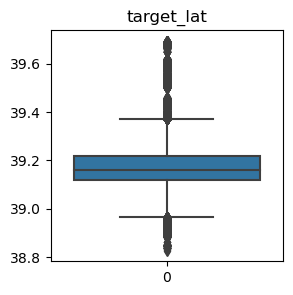

<Figure size 640x480 with 0 Axes>

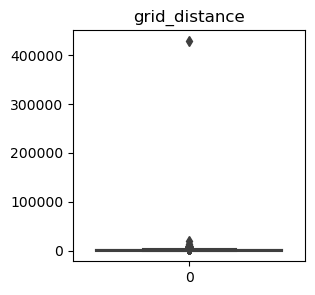

<Figure size 640x480 with 0 Axes>

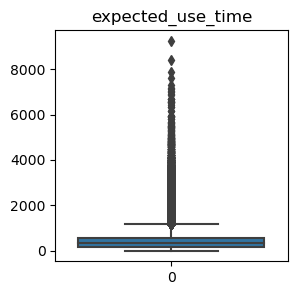

<Figure size 640x480 with 0 Axes>

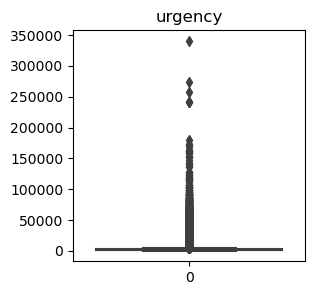

<Figure size 640x480 with 0 Axes>

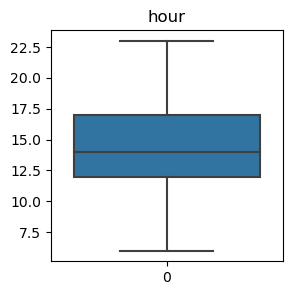

<Figure size 640x480 with 0 Axes>

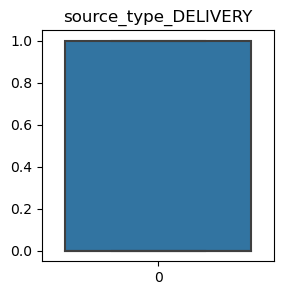

<Figure size 640x480 with 0 Axes>

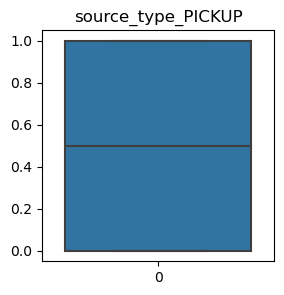

<Figure size 640x480 with 0 Axes>

In [12]:
for col in temp1.columns:
    plt.figure(figsize = (3,3))
    plt.title(col)
    sns.boxplot(data = temp1[col])
    plt.savefig(str(col)+'.png', bbox_inches= 'tight')
    plt.show()
    plt.clf()

In [13]:
# Define function to convert outliers to NA
def outlier_to_null(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    IQR = q3 - q1
    lb = q1 - 1.5 * IQR
    ub = q3 + 1.5 * IQR
    for x in [col]:
        data.loc[data[col] < lb, x] = np.nan
        data.loc[data[col] > ub, x] = np.nan

In [14]:
temp1.columns

Index(['courier_wave_start_lng', 'courier_wave_start_lat', 'level', 'speed',
       'max_load', 'weather_grade', 'source_lng', 'source_lat', 'target_lng',
       'target_lat', 'grid_distance', 'expected_use_time', 'urgency', 'hour',
       'source_type_DELIVERY', 'source_type_PICKUP'],
      dtype='object')

In [15]:
cols = ['courier_wave_start_lng', 'courier_wave_start_lat', 'level', 'speed',
       'max_load', 'source_lng', 'source_lat', 'target_lng',
       'target_lat', 'grid_distance', 'expected_use_time', 'urgency'] 

for col in cols:
    outlier_to_null(temp1, col)

In [16]:
temp1.isna().sum()

courier_wave_start_lng    23584
courier_wave_start_lat    35936
level                     13732
speed                      1542
max_load                  21528
weather_grade                 0
source_lng                23894
source_lat                37452
target_lng                24135
target_lat                36144
grid_distance             13251
expected_use_time         26314
urgency                   21149
hour                          0
source_type_DELIVERY          0
source_type_PICKUP            0
dtype: int64

In [17]:
temp1.dropna(inplace = True)

In [18]:
temp1.describe()

,courier_wave_start_lng,courier_wave_start_lat,level,speed,max_load,weather_grade,source_lng,source_lat,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour,source_type_DELIVERY,source_type_PICKUP
count,"378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000","378,504.000000"
mean,121.525562,39.166419,2.689977,5.331687,9.177636,3.503028,121.525518,39.166515,121.525498,39.166583,984.885886,366.892329,"1,748.575082",14.507625,0.343629,0.525101
std,0.103832,0.073962,0.544531,0.596845,1.673630,1.010755,0.103659,0.073744,0.103728,0.073872,817.063072,268.413773,"1,017.200784",3.287377,0.474920,0.499370
min,121.223597,38.965286,1.000000,3.504931,5.000000,1.000000,121.223494,38.966411,121.223633,38.964651,0.000000,1.000000,0.000000,7.000000,0.000000,0.000000
25%,121.453259,39.116967,2.000000,4.887440,8.000000,4.000000,121.454071,39.117357,121.454164,39.117271,306.000000,175.000000,865.000000,12.000000,0.000000,0.000000
50%,121.524155,39.157846,3.000000,5.444242,9.000000,4.000000,121.524204,39.157099,121.523894,39.157031,828.000000,328.000000,"1,657.000000",14.000000,0.000000,1.000000
75%,121.581883,39.208914,3.000000,5.744762,10.000000,4.000000,121.581976,39.208224,121.582069,39.208254,"1,480.000000",521.000000,"2,501.000000",18.000000,1.000000,1.000000
max,121.813000,39.369796,3.000000,6.943103,13.000000,4.000000,121.812094,39.369011,121.811930,39.371501,"3,435.000000","1,176.000000","5,286.000000",23.000000,1.000000,1.000000


In [19]:
cor_reg = temp1.drop(['expected_use_time'], axis = 1)

<function matplotlib.pyplot.show(close=None, block=None)>

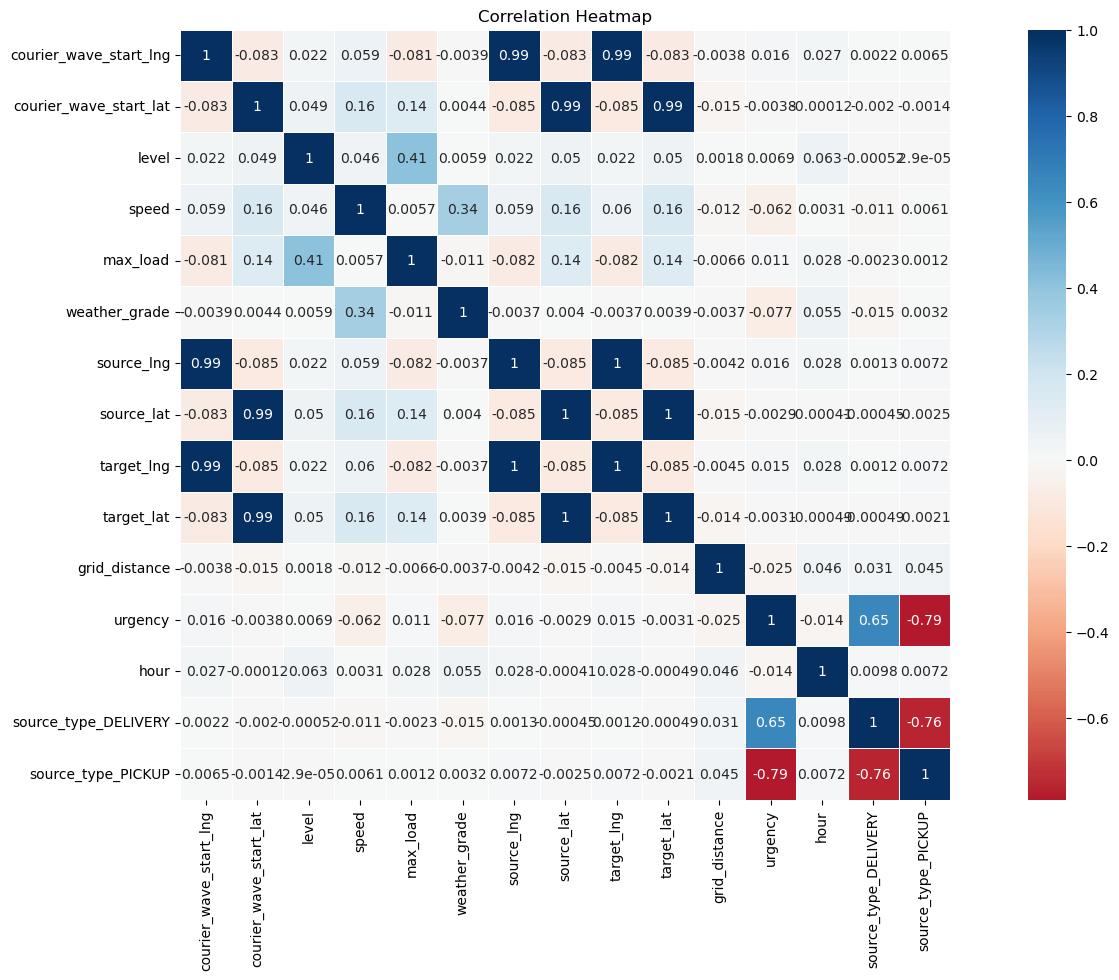

In [20]:
plt.figure(figsize = (20,10))
sns.heatmap(cor_reg.corr(), annot = True, cmap = "RdBu", center = 0,  vmax = 1, square = True, linewidths = 0.5)
plt.title('Correlation Heatmap')
plt.savefig('cor1.png', bbox_inches = 'tight')
plt.show

# Baseline Model

In [21]:
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.linear_model import LinearRegression

In [22]:
LinReg = LinearRegression()
cv = cross_validate

In [23]:
X = temp1.drop(['expected_use_time'], axis = 1)
y = temp1['expected_use_time']

cv1 = cv(LinReg, X, y, scoring = 'neg_mean_absolute_error', cv = 5, return_train_score = True)
print('The MAE of the baseline model is',abs(cv1['test_score'].mean()))

The MAE of the baseline model is 160.3689448690444


# XGBoost model

In [24]:
import xgboost as xgb

In [25]:
grid_params = {'max_depth': range(5,8), 'learning_rate': [0.01, 0.05, 0.1]}

In [26]:
grid = GridSearchCV(xgb.XGBRegressor(objective ='reg:squarederror', colsample_bynode = 0.8, reg_lambda = 1, 
                         eval_metric = 'mae', gamma = 0.001), grid_params, scoring = 'neg_mean_absolute_error', 
                    cv = 5)

In [27]:
grid.fit(X, y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=0.8, colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric='mae',
                                    gamma=0.001, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                   

In [28]:
grid.best_score_

-146.4248986845261

In [29]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 7}

In [30]:
model1 = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bynode = 0.8, reg_lambda=1, 
                         learning_rate = 0.1, gamma = 0.001, max_depth = 7, n_estimators=50).fit(X,y)

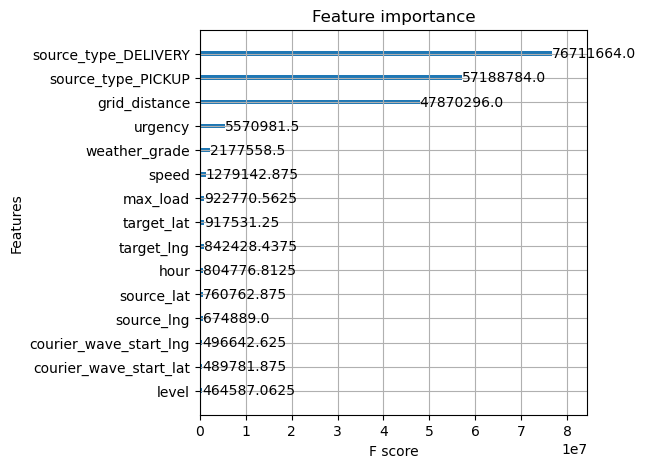

In [31]:
fig, ax = plt.subplots(figsize = (5,5))
xgb.plot_importance(model1, ax = ax,importance_type='gain')
plt.savefig('FI_Reg.png', bbox_inches = 'tight')
plt.show()

# Drop irrelevant features

In [32]:
temp2 = df.drop(['courier_wave_start_lat', 'courier_wave_start_lng', 'level', 'source_lat',
                'source_lng'], axis = 1)

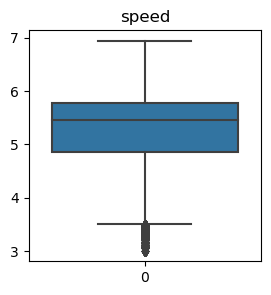

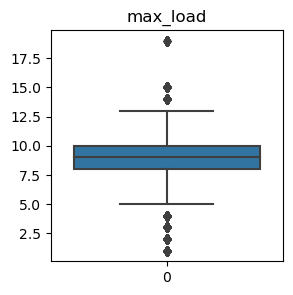

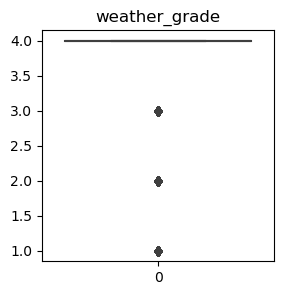

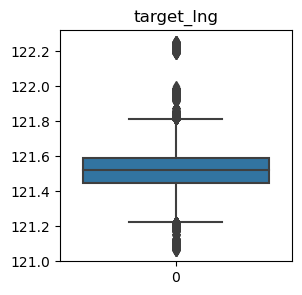

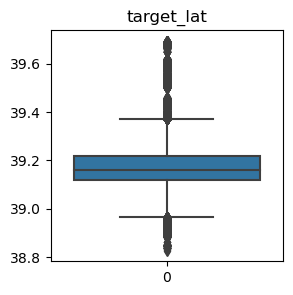

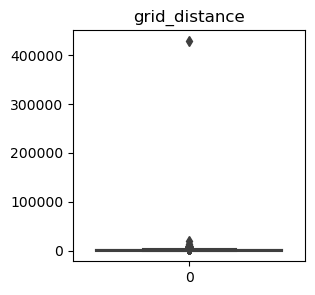

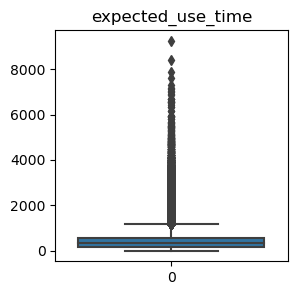

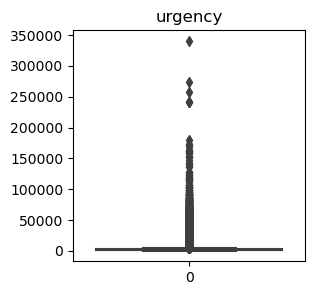

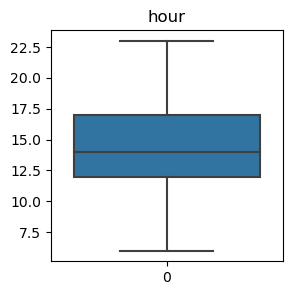

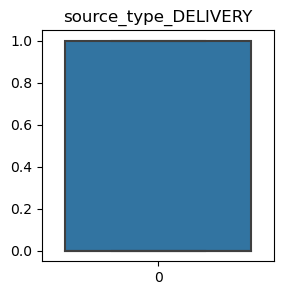

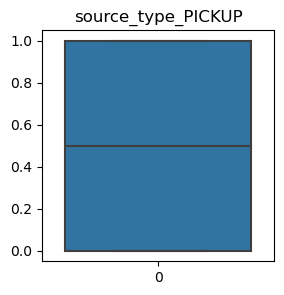

In [33]:
for col in temp2.columns:
    plt.figure(figsize = (3,3))
    plt.title(col)
    sns.boxplot(data = temp2[col])

In [34]:
temp2.columns

Index(['speed', 'max_load', 'weather_grade', 'target_lng', 'target_lat',
       'grid_distance', 'expected_use_time', 'urgency', 'hour',
       'source_type_DELIVERY', 'source_type_PICKUP'],
      dtype='object')

In [35]:
cols = ['speed', 'max_load', 'target_lng', 'target_lat',
       'grid_distance', 'expected_use_time', 'urgency']

for col in cols:
    outlier_to_null(temp2, col)

In [36]:
temp2.isna().sum()

speed                    1542
max_load                21528
weather_grade               0
target_lng              24135
target_lat              36144
grid_distance           13251
expected_use_time       26314
urgency                 21149
hour                        0
source_type_DELIVERY        0
source_type_PICKUP          0
dtype: int64

In [37]:
temp2.dropna(inplace = True)

In [38]:
temp2.describe()

,speed,max_load,weather_grade,target_lng,target_lat,grid_distance,expected_use_time,urgency,hour,source_type_DELIVERY,source_type_PICKUP
count,"390,567.000000","390,567.000000","390,567.000000","390,567.000000","390,567.000000","390,567.000000","390,567.000000","390,567.000000","390,567.000000","390,567.000000","390,567.000000"
mean,5.333423,9.169850,3.498959,121.524218,39.166791,987.234991,366.816016,"1,748.013790",14.505155,0.344123,0.525375
std,0.600877,1.690775,1.014072,0.105908,0.075124,818.868517,268.438003,"1,018.340144",3.289876,0.475082,0.499356
min,3.504931,5.000000,1.000000,121.223624,38.964631,0.000000,1.000000,0.000000,7.000000,0.000000,0.000000
25%,4.877935,8.000000,4.000000,121.451724,39.117361,306.000000,175.000000,864.000000,12.000000,0.000000,0.000000
50%,5.445360,9.000000,4.000000,121.523429,39.156500,830.000000,328.000000,"1,649.000000",14.000000,0.000000,1.000000
75%,5.748643,10.000000,4.000000,121.582044,39.208479,"1,484.000000",521.000000,"2,502.000000",18.000000,1.000000,1.000000
max,6.943103,13.000000,4.000000,121.811934,39.371501,"3,435.000000","1,176.000000","5,286.000000",23.000000,1.000000,1.000000


# Re-modeling

In [39]:
X = temp2.drop(['expected_use_time'], axis = 1)
y = temp2['expected_use_time']

In [40]:
grid_params = {'learning_rate': [0.05, 0.1, 0.2], 'n_estimators':np.arange(400, 900, 100)}

grid = GridSearchCV(xgb.XGBRegressor(objective ='reg:squarederror', eval_metric = 'mae', colsample_bynode=0.8,
                                     reg_lambda = 1, gamma = 0.001, max_depth = 7),
                    grid_params, scoring = 'neg_mean_absolute_error', cv = 5)

grid.fit(X,y)

print(grid.best_score_)

print(grid.best_params_)


-144.53396647806056
{'learning_rate': 0.1, 'n_estimators': 800}


In [42]:
model2 = xgb.XGBRegressor(objective = 'reg:squarederror', colsample_bynode = 0.8, reg_lambda = 1, 
                         learning_rate = 0.1, gamma = 0.001, max_depth = 7, n_estimators = 800).fit(X,y)

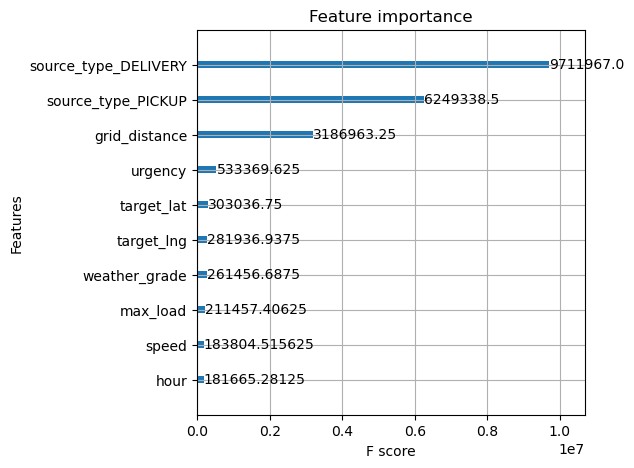

In [43]:
fig, ax = plt.subplots(figsize = (5,5))
xgb.plot_importance(model2, ax = ax,importance_type = 'gain')
plt.savefig('FI_Reg2.png', bbox_inches = 'tight')
plt.show()

# Prediction

In [75]:
test = pd.read_csv('dataframe_test.csv')
test.head()

,courier_id,wave_index,tracking_id,courier_wave_start_lng,courier_wave_start_lat,date,group,level,speed,max_load,weather_grade,aoi_id,shop_id,id,source_type,source_tracking_id,source_lng,source_lat,target_lng,target_lat,grid_distance,urgency,hour
0,10007871,2,"2,100,000,000,000,000,000.000000",121.630558,39.140900,20200228,"20,200,000,000,000,000.000000",3,5.535851,11,Normal Weather,bf49288eb197bc6b44fa0573acf8c74d,34887bf8e1a0de848d271bc6b7059670,509790,ASSIGN,2.10E+18,121.630558,39.140900,121.629930,39.144603,796.000000,1776,13
1,10007871,2,"2,100,000,000,000,000,000.000000",121.630558,39.140900,20200228,"20,200,000,000,000,000.000000",3,5.535851,11,Normal Weather,bf49288eb197bc6b44fa0573acf8c74d,34887bf8e1a0de848d271bc6b7059670,509791,PICKUP,2.10E+18,121.629930,39.144603,121.629604,39.150661,"1,048.000000",697,13
2,10007871,2,"2,100,000,000,000,000,000.000000",121.630558,39.140900,20200228,"20,200,000,000,000,000.000000",3,5.535851,11,Normal Weather,9291e6fede798be58711cf53419eb285,34887bf8e1a0de848d271bc6b7059670,509792,DELIVERY,2.10E+18,121.629604,39.150661,121.629930,39.144603,"1,019.000000",1756,13
3,10007871,2,"2,100,000,000,000,000,000.000000",121.630558,39.140900,20200228,"20,200,000,000,000,000.000000",3,5.535851,11,Normal Weather,9291e6fede798be58711cf53419eb285,34887bf8e1a0de848d271bc6b7059670,509793,PICKUP,2.10E+18,121.629930,39.144603,121.630544,39.152711,"1,198.000000",676,13
4,10007871,2,"2,100,000,000,000,000,000.000000",121.630558,39.140900,20200228,"20,200,000,000,000,000.000000",3,5.535851,11,Normal Weather,4fdb588dc34ac31ce738a32696315b5d,5e65ed920db306852d16f1ec176011ed,509794,DELIVERY,2.10E+18,121.630544,39.152711,121.631446,39.142762,"1,275.000000",2336,14


In [76]:
X.columns

Index(['speed', 'max_load', 'weather_grade', 'target_lng', 'target_lat',
       'grid_distance', 'urgency', 'hour', 'source_type_DELIVERY',
       'source_type_PICKUP'],
      dtype='object')

In [77]:
test = test[['speed', 'max_load', 'weather_grade', 'target_lng', 'target_lat',
       'grid_distance', 'urgency', 'hour', 'source_type']]

In [78]:
for col in test.select_dtypes(include = 'object').columns:
     print(col, ':', test[col].unique(), ',', 'Numbers:',test[col].nunique(),'\n')

weather_grade : ['Normal Weather' 'Slightly Bad Weather' 'Bad Weather' 'Very Bad Weather'] , Numbers: 4 

source_type : ['ASSIGN' 'PICKUP' 'DELIVERY' '2.10E+18'] , Numbers: 4 



In [80]:
import random
test.loc[test['source_type'] == '2.10E+18', 'source_type'] = random.choice(['ASSIGN','PICKUP','DELIVERY'])

In [81]:
# Encode weather condition into ordinal number, source type into dummy variables
test['weather_grade'].replace({'Very Bad Weather':1, 'Bad Weather':2,
                             'Slightly Bad Weather':3, 'Normal Weather':4}, inplace = True)

In [82]:
test = pd.get_dummies(data = test, columns = ['source_type'], drop_first = True)

In [84]:
test.describe()

,speed,max_load,weather_grade,target_lng,target_lat,grid_distance,urgency,hour,source_type_DELIVERY,source_type_PICKUP
count,"25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000"
mean,5.649952,8.908277,3.996309,121.534047,39.178784,"1,030.252759","1,528.235668",14.851539,0.359549,0.499921
std,0.480385,2.165763,0.065618,0.146604,0.113424,921.641202,"3,982.104312",3.365520,0.479878,0.500010
min,4.114584,1.000000,1.000000,121.083904,38.836801,0.000000,"-161,639.000000",7.000000,0.000000,0.000000
25%,5.363043,8.000000,4.000000,121.439104,39.116259,299.000000,847.000000,12.000000,0.000000,0.000000
50%,5.640524,9.000000,4.000000,121.523875,39.162166,821.000000,"1,708.500000",15.000000,0.000000,0.000000
75%,5.942733,10.000000,4.000000,121.595742,39.214574,"1,498.250000","2,509.000000",18.000000,1.000000,1.000000
max,6.914215,19.000000,4.000000,122.253524,39.688901,"7,978.000000","10,792.000000",23.000000,1.000000,1.000000


In [85]:
test['urgency'] = abs(test['urgency'])

In [86]:
# Define function to convert outliers to the boundary
def outlier_to_boundary(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    IQR = q3 - q1
    lb = q1 - 1.5 * IQR
    ub = q3 + 1.5 * IQR
    for x in [col]:
        data.loc[data[col] < lb, x] = lb
        data.loc[data[col] > ub, x] = ub

In [87]:
cols = test.columns
cols = cols.drop('weather_grade')

In [88]:
for col in cols:
    outlier_to_boundary(test, col)

In [89]:
test.describe()

,speed,max_load,weather_grade,target_lng,target_lat,grid_distance,urgency,hour,source_type_DELIVERY,source_type_PICKUP
count,"25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000","25,468.000000"
mean,5.654097,8.982880,3.996309,121.529342,39.172065,"1,013.420385","1,807.282668",14.851539,0.359549,0.499921
std,0.468094,1.926197,0.065618,0.130676,0.089889,868.596175,"1,132.642839",3.365520,0.479878,0.500010
min,4.493508,5.000000,1.000000,121.204148,38.968786,0.000000,0.000000,7.000000,0.000000,0.000000
25%,5.363043,8.000000,4.000000,121.439104,39.116259,299.000000,856.000000,12.000000,0.000000,0.000000
50%,5.640524,9.000000,4.000000,121.523875,39.162166,821.000000,"1,752.000000",15.000000,0.000000,0.000000
75%,5.942733,10.000000,4.000000,121.595742,39.214574,"1,498.250000","2,548.000000",18.000000,1.000000,1.000000
max,6.812267,13.000000,4.000000,121.830698,39.362046,"3,297.125000","5,086.000000",23.000000,1.000000,1.000000


In [90]:
y_pred = model2.predict(test)

In [91]:
result = pd.DataFrame(
{
    'order': np.arange(0,len(y_pred)),
    'expected_use_time':y_pred
})

In [93]:
result.to_csv('Regression.csv', index = False)